# 第37章: 拡散モデルの理論（基礎編）

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] VAEから拡散モデルへの発展を理解できる
- [ ] 拡散過程（forward process）を説明できる
- [ ] 逆拡散過程（reverse process）を説明できる
- [ ] 拡散モデルの直感的な理解を得る

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 34（EMアルゴリズム、ELBO）
- ✅ Notebook 36（VAE）
- ✅ 正規分布とKLダイバージェンス

⏱️ **推定学習時間**: 150-180分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 理論

---

## 🌟 はじめに

**拡散モデル（Diffusion Models）**は、2020年にDDPM（Denoising Diffusion Probabilistic Models）として注目を集め、現在ではStable DiffusionやDALL-E 3などの画像生成AIの基盤技術となっています。

### 🤔 拡散モデルのアイデア

拡散モデルの基本的なアイデアは非常にシンプルです：

1. **拡散過程（Forward Process）**: 画像に少しずつノイズを加えて、最終的に完全なノイズにする
2. **逆拡散過程（Reverse Process）**: ノイズから少しずつノイズを除去して、元の画像を復元する

```
画像 x₀ → x₁ → x₂ → ... → xₜ → ... → x_T (純粋なノイズ)
      ←   ←   ←   ... ←   ←   ... ←
```

### 📊 VAEとの関係

拡散モデルは、VAEを「多段階化」したものと捉えることができます：

| 項目 | VAE | 拡散モデル |
|------|-----|------------|
| 潜在変数 | 1つ (z) | T個 (x₁, x₂, ..., x_T) |
| エンコード | 1ステップ | Tステップ（ノイズ追加） |
| デコード | 1ステップ | Tステップ（ノイズ除去） |
| 学習 | エンコーダ + デコーダ | デコーダのみ（エンコーダは固定） |

In [1]:
# ============================================================
# 環境設定
# 必要なライブラリをインポートします
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 警告を非表示
warnings.filterwarnings('ignore')

# グラフスタイルの設定
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic',
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

# デバイス
device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

# 再現性
torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
Device: mps
✅ ライブラリのインポート完了


---

## 1. VAEから拡散モデルへ

### 🤔 VAEの復習

VAEは1つの潜在変数 $z$ を使って、データ $x$ を生成します：

$$p(x) = \int p(x|z) p(z) dz$$

- **エンコーダ** $q(z|x)$: 入力 → 潜在変数
- **デコーダ** $p(x|z)$: 潜在変数 → 再構成

### 📊 階層型VAE

潜在変数を複数の層に分けることを考えます：

$$p(x) = \int p(x|z_1) p(z_1|z_2) \cdots p(z_{T-1}|z_T) p(z_T) dz_1 \cdots dz_T$$

これは「階層型VAE」と呼ばれ、拡散モデルの基本形になります。

### 📊 拡散モデルの特徴

拡散モデルでは：

1. **潜在変数 = ノイズを加えた画像**: $z_t = x_t$（データと同じ次元）
2. **エンコーダは固定**: 学習不要（単純なノイズ追加）
3. **デコーダのみ学習**: ノイズ除去を学習

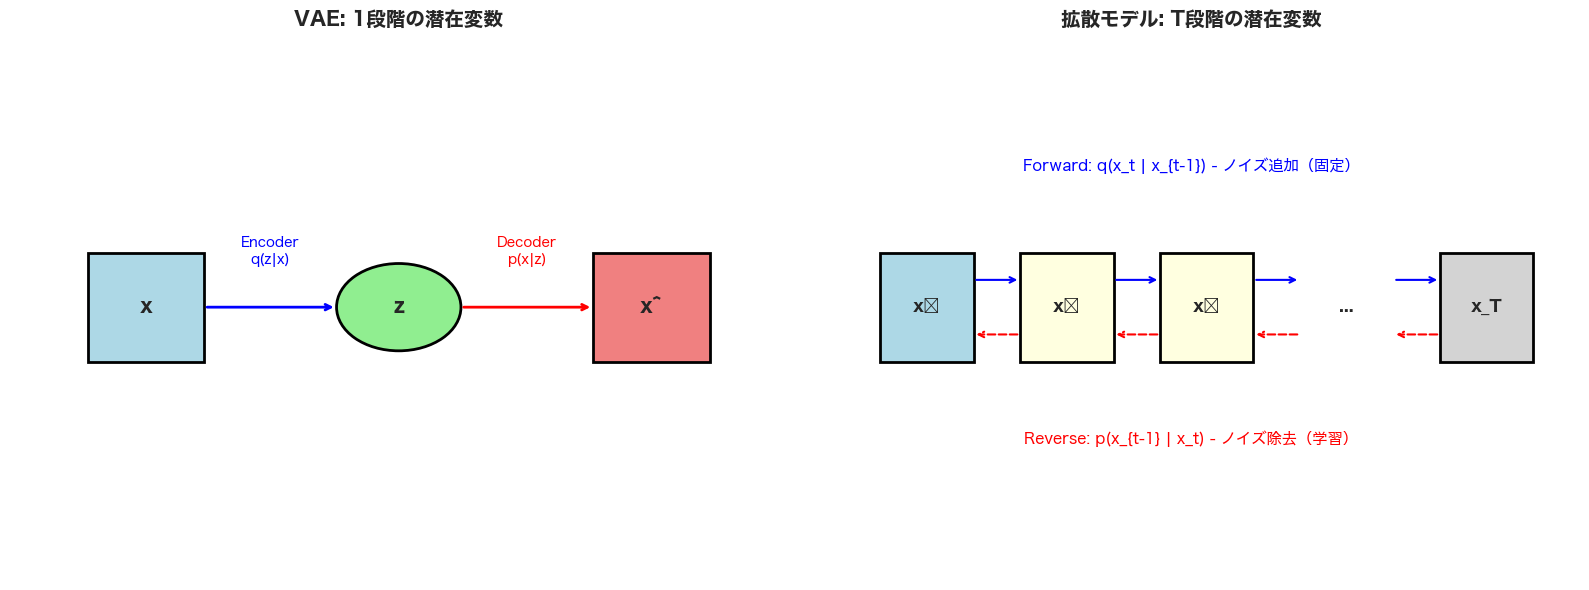

In [2]:
# ============================================================
# VAEと拡散モデルの対比図
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左: VAE
ax = axes[0]
ax.set_title('VAE: 1段階の潜在変数', fontsize=14, fontweight='bold')

# ボックス
ax.add_patch(plt.Rectangle((0.1, 0.4), 0.15, 0.2, color='lightblue', ec='black', lw=2))
ax.text(0.175, 0.5, 'x', ha='center', va='center', fontsize=14, fontweight='bold')

ax.add_patch(plt.Circle((0.5, 0.5), 0.08, color='lightgreen', ec='black', lw=2))
ax.text(0.5, 0.5, 'z', ha='center', va='center', fontsize=14, fontweight='bold')

ax.add_patch(plt.Rectangle((0.75, 0.4), 0.15, 0.2, color='lightcoral', ec='black', lw=2))
ax.text(0.825, 0.5, 'x̂', ha='center', va='center', fontsize=14, fontweight='bold')

# 矢印
ax.annotate('', xy=(0.42, 0.5), xytext=(0.25, 0.5),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax.text(0.335, 0.58, 'Encoder\nq(z|x)', ha='center', fontsize=10, color='blue')

ax.annotate('', xy=(0.75, 0.5), xytext=(0.58, 0.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.text(0.665, 0.58, 'Decoder\np(x|z)', ha='center', fontsize=10, color='red')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# 右: 拡散モデル
ax = axes[1]
ax.set_title('拡散モデル: T段階の潜在変数', fontsize=14, fontweight='bold')

# 複数のボックス
positions = [0.1, 0.28, 0.46, 0.64, 0.82]
labels = ['x₀', 'x₁', 'x₂', '...', 'x_T']
colors = ['lightblue', 'lightyellow', 'lightyellow', 'white', 'lightgray']

for i, (pos, label, color) in enumerate(zip(positions, labels, colors)):
    if label != '...':
        ax.add_patch(plt.Rectangle((pos, 0.4), 0.12, 0.2, color=color, ec='black', lw=2))
    ax.text(pos + 0.06, 0.5, label, ha='center', va='center', fontsize=12, fontweight='bold')

# 矢印（Forward）
for i in range(len(positions) - 1):
    ax.annotate('', xy=(positions[i+1], 0.55), xytext=(positions[i] + 0.12, 0.55),
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))

# 矢印（Reverse）
for i in range(len(positions) - 1):
    ax.annotate('', xy=(positions[i] + 0.12, 0.45), xytext=(positions[i+1], 0.45),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5, ls='--'))

ax.text(0.5, 0.75, 'Forward: q(x_t | x_{t-1}) - ノイズ追加（固定）', 
        ha='center', fontsize=11, color='blue')
ax.text(0.5, 0.25, 'Reverse: p(x_{t-1} | x_t) - ノイズ除去（学習）', 
        ha='center', fontsize=11, color='red')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

---

## 2. 拡散過程（Forward Process）

### 🤔 拡散過程とは？

拡散過程は、元の画像 $x_0$ に少しずつガウスノイズを加えて、最終的に純粋なノイズ $x_T \sim \mathcal{N}(0, I)$ にする過程です。

### 📊 各ステップの定義

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I)$$

ここで $\beta_t$ は**ノイズスケジュール**と呼ばれるハイパーパラメータです。

### 📊 直感的な理解

各ステップで：
- 前のステップの画像を $\sqrt{1 - \beta_t}$ 倍に縮小
- 分散 $\beta_t$ のガウスノイズを追加

これにより、画像の信号が徐々に減衰し、ノイズが増えていきます。

In [3]:
# ============================================================
# MNISTデータの読み込み
# ============================================================

transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# サンプル画像を取得
sample_image = mnist.data[0].float() / 255.0  # [0, 1]に正規化
sample_image = sample_image.unsqueeze(0)  # (1, 28, 28)

print(f"画像サイズ: {sample_image.shape}")
print(f"値の範囲: [{sample_image.min():.2f}, {sample_image.max():.2f}]")

画像サイズ: torch.Size([1, 28, 28])
値の範囲: [0.00, 1.00]


In [4]:
# ============================================================
# 拡散過程の実装
# 1ステップずつノイズを追加する
# ============================================================

def get_beta_schedule(T, schedule='linear', beta_start=1e-4, beta_end=0.02):
    """
    ノイズスケジュールを生成
    
    Parameters:
    -----------
    T : int
        総ステップ数
    schedule : str
        'linear' または 'cosine'
    """
    if schedule == 'linear':
        return torch.linspace(beta_start, beta_end, T)
    elif schedule == 'cosine':
        # Cosineスケジュール（より滑らかな拡散）
        steps = torch.linspace(0, T, T + 1)
        alpha_bar = torch.cos((steps / T + 0.008) / 1.008 * np.pi / 2) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        betas = 1 - alpha_bar[1:] / alpha_bar[:-1]
        return torch.clamp(betas, 0.0001, 0.999)
    else:
        raise ValueError(f"Unknown schedule: {schedule}")


def forward_diffusion_step(x_t, t, betas):
    """
    1ステップの拡散過程
    q(x_t | x_{t-1}) = N(sqrt(1-beta_t) * x_{t-1}, beta_t * I)
    """
    beta_t = betas[t]
    noise = torch.randn_like(x_t)
    x_next = torch.sqrt(1 - beta_t) * x_t + torch.sqrt(beta_t) * noise
    return x_next, noise


# パラメータ設定
T = 1000  # 総ステップ数
betas = get_beta_schedule(T, schedule='linear')

print(f"総ステップ数 T = {T}")
print(f"β の範囲: [{betas[0]:.6f}, {betas[-1]:.6f}]")

総ステップ数 T = 1000
β の範囲: [0.000100, 0.020000]


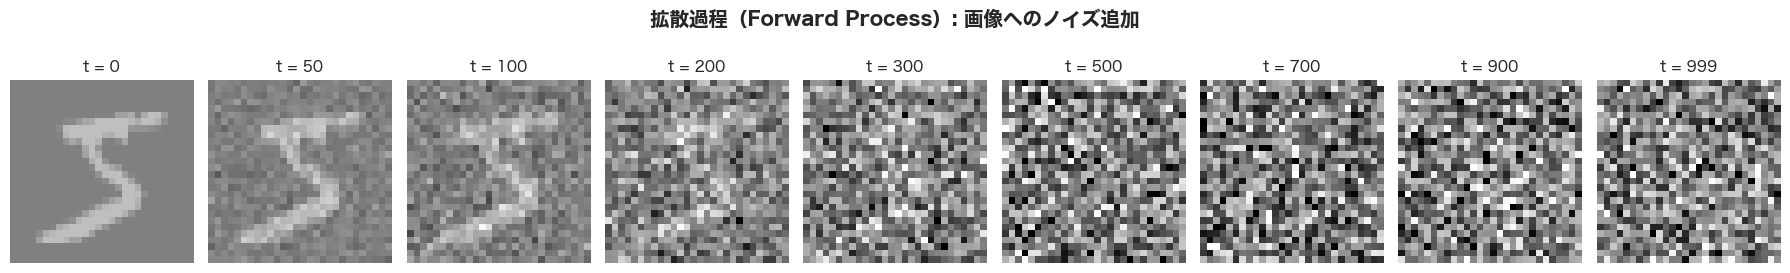

💡 観察ポイント:
  - t=0: 元の画像（数字 '5'）
  - t が増加: 徐々にノイズが増える
  - t=999: ほぼ純粋なガウスノイズ


In [5]:
# ============================================================
# 拡散過程の可視化
# 各タイムステップでの画像を表示
# ============================================================

# 表示するタイムステップ
display_steps = [0, 50, 100, 200, 300, 500, 700, 900, 999]

# 拡散過程を実行
x = sample_image.clone()
diffusion_images = {0: x.clone()}

for t in range(T):
    x, _ = forward_diffusion_step(x, t, betas)
    if t + 1 in display_steps:
        diffusion_images[t + 1] = x.clone()

# 可視化
fig, axes = plt.subplots(1, len(display_steps), figsize=(18, 3))

for idx, t in enumerate(display_steps):
    img = diffusion_images[t].squeeze().numpy()
    axes[idx].imshow(img, cmap='gray', vmin=-2, vmax=2)
    axes[idx].set_title(f't = {t}', fontsize=11)
    axes[idx].axis('off')

plt.suptitle('拡散過程（Forward Process）: 画像へのノイズ追加', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 観察ポイント:")
print("  - t=0: 元の画像（数字 '5'）")
print("  - t が増加: 徐々にノイズが増える")
print("  - t=999: ほぼ純粋なガウスノイズ")

---

## 3. 重要な数学的性質：任意のステップへの直接ノイズ追加

### 🤔 問題点

1ステップずつノイズを追加すると、$t=500$ の画像を得るには500回の計算が必要です。

### 📊 解決策：閉形式の式

実は、$x_0$ から直接 $x_t$ をサンプリングできます：

$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)$$

ここで：
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$（累積積）

### 📊 再パラメータ化

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

これにより、訓練時に効率的にノイズを追加できます。

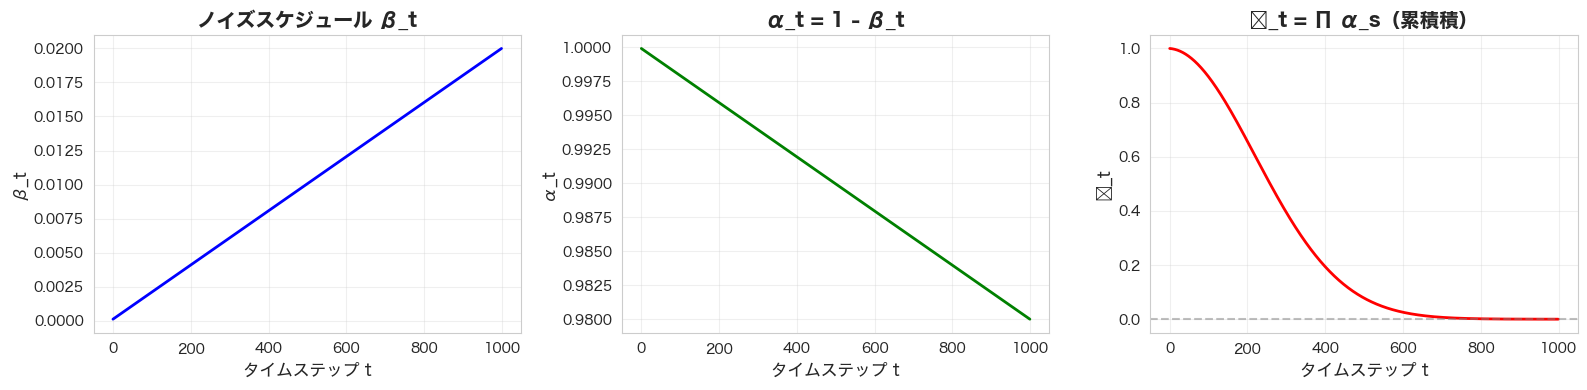

α_bar[0] = 0.9999（ほぼ1: 元の画像に近い）
α_bar[499] = 0.0786（中間）
α_bar[999] = 0.000040（ほぼ0: 純粋なノイズ）


In [6]:
# ============================================================
# α_bar の計算と可視化
# ============================================================

# α_t = 1 - β_t
alphas = 1 - betas

# α_bar_t = Π_{s=1}^{t} α_s (累積積)
alpha_bars = torch.cumprod(alphas, dim=0)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# β_t
ax = axes[0]
ax.plot(betas.numpy(), 'b-', linewidth=2)
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('β_t', fontsize=12)
ax.set_title('ノイズスケジュール β_t', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# α_t
ax = axes[1]
ax.plot(alphas.numpy(), 'g-', linewidth=2)
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('α_t', fontsize=12)
ax.set_title('α_t = 1 - β_t', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# α_bar_t
ax = axes[2]
ax.plot(alpha_bars.numpy(), 'r-', linewidth=2)
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('ᾱ_t', fontsize=12)
ax.set_title('ᾱ_t = Π α_s（累積積）', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"α_bar[0] = {alpha_bars[0]:.4f}（ほぼ1: 元の画像に近い）")
print(f"α_bar[499] = {alpha_bars[499]:.4f}（中間）")
print(f"α_bar[999] = {alpha_bars[999]:.6f}（ほぼ0: 純粋なノイズ）")

In [7]:
# ============================================================
# 直接ノイズ追加の実装
# q(x_t | x_0) からサンプリング
# ============================================================

def add_noise_direct(x_0, t, alpha_bars):
    """
    x_0 から直接 x_t をサンプリング
    
    x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * epsilon
    """
    alpha_bar_t = alpha_bars[t]
    noise = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    return x_t, noise


# 検証: 逐次追加と直接追加の比較
torch.manual_seed(42)

# 直接ノイズ追加
x_direct, noise_direct = add_noise_direct(sample_image, 500, alpha_bars)

print("直接ノイズ追加:")
print(f"  x_t の平均: {x_direct.mean():.4f}")
print(f"  x_t の標準偏差: {x_direct.std():.4f}")

直接ノイズ追加:
  x_t の平均: 0.0609
  x_t の標準偏差: 0.9561


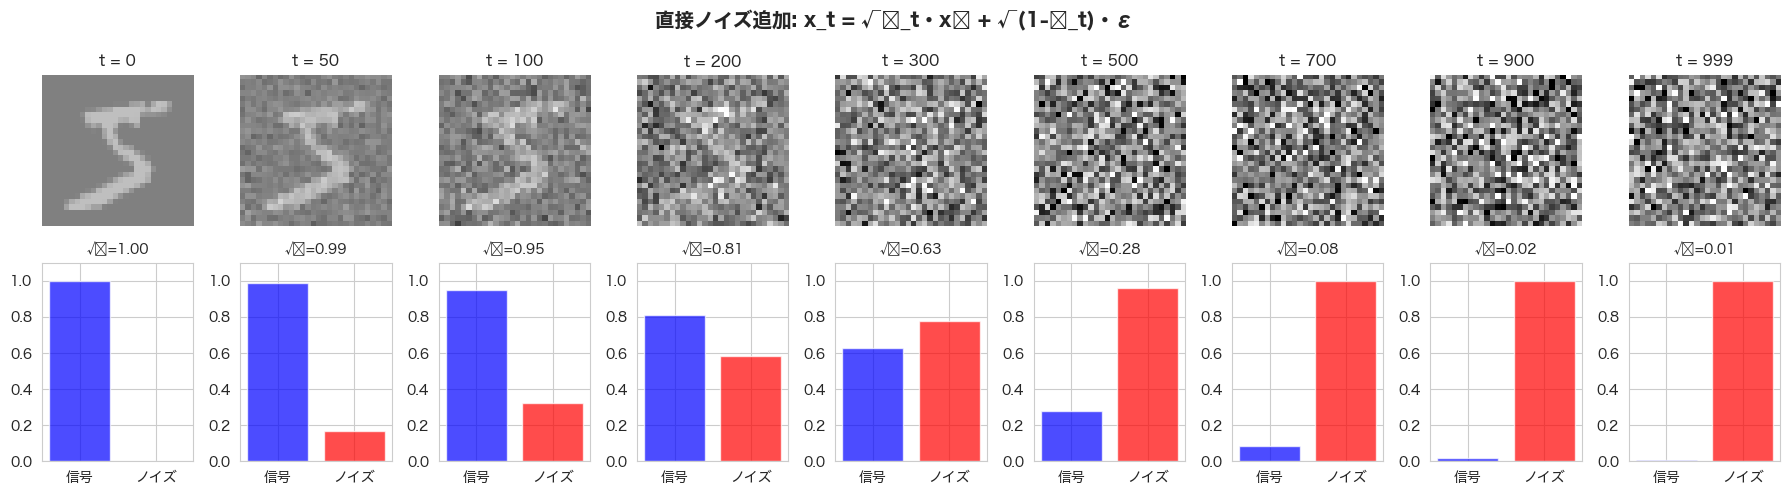

In [8]:
# ============================================================
# 直接ノイズ追加の可視化
# 様々な t での結果を比較
# ============================================================

fig, axes = plt.subplots(2, len(display_steps), figsize=(18, 5))

torch.manual_seed(42)

for idx, t in enumerate(display_steps):
    if t == 0:
        x_t = sample_image
        signal_ratio = 1.0
        noise_ratio = 0.0
    else:
        x_t, _ = add_noise_direct(sample_image, t-1, alpha_bars)
        signal_ratio = torch.sqrt(alpha_bars[t-1]).item()
        noise_ratio = torch.sqrt(1 - alpha_bars[t-1]).item()
    
    # 画像
    axes[0, idx].imshow(x_t.squeeze().numpy(), cmap='gray', vmin=-2, vmax=2)
    axes[0, idx].set_title(f't = {t}', fontsize=11)
    axes[0, idx].axis('off')
    
    # 信号とノイズの比率
    axes[1, idx].bar(['信号', 'ノイズ'], [signal_ratio, noise_ratio], 
                     color=['blue', 'red'], alpha=0.7)
    axes[1, idx].set_ylim(0, 1.1)
    axes[1, idx].set_title(f'√ᾱ={signal_ratio:.2f}', fontsize=10)

plt.suptitle('直接ノイズ追加: x_t = √ᾱ_t・x₀ + √(1-ᾱ_t)・ε', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 4. 逆拡散過程（Reverse Process）

### 🤔 目標

逆拡散過程の目標は、ノイズ $x_T$ から元の画像 $x_0$ を復元することです：

$$x_T \rightarrow x_{T-1} \rightarrow \cdots \rightarrow x_1 \rightarrow x_0$$

### 📊 逆過程の定義

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

- $\mu_\theta$: ニューラルネットワークで予測する平均
- $\Sigma_\theta$: 分散（多くの場合、固定値を使用）

### 📊 重要な事実

拡散過程が十分に小さなステップサイズで行われる場合、逆過程も正規分布で近似できることが知られています。これが拡散モデルの理論的な基盤です。

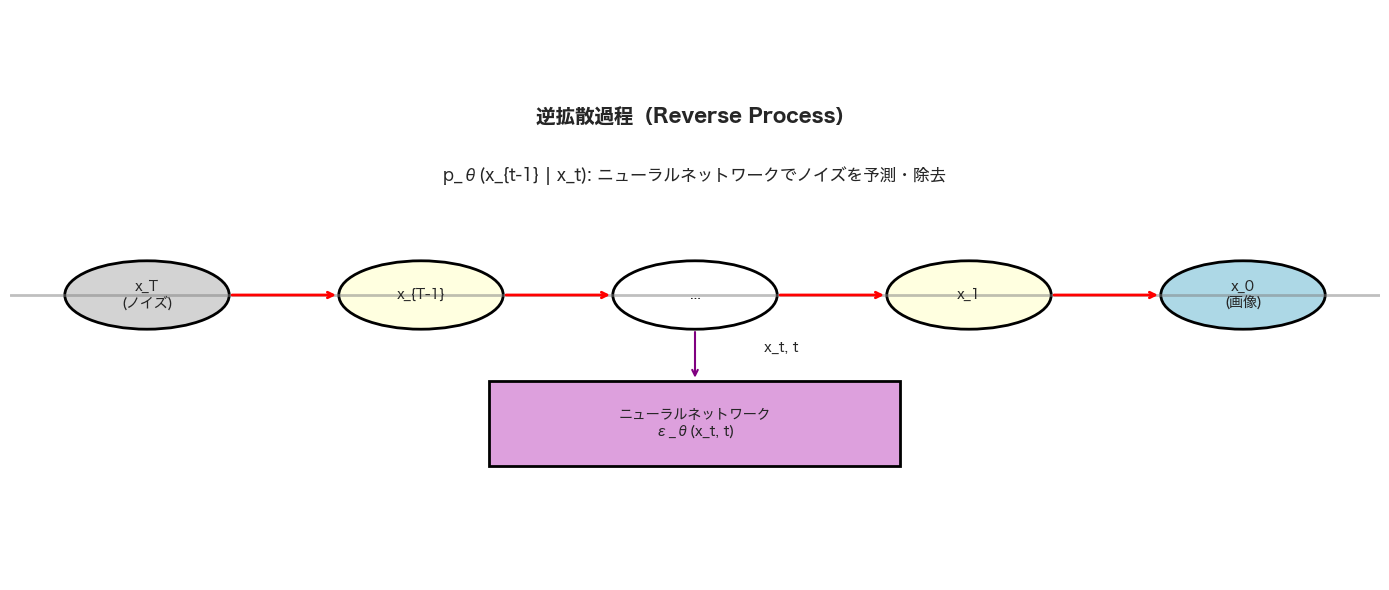

In [9]:
# ============================================================
# 逆拡散過程の概念図
# ============================================================

fig, ax = plt.subplots(figsize=(14, 6))

# タイムライン
ax.axhline(y=0.5, color='gray', linestyle='-', linewidth=2, alpha=0.5)

# ノード
positions = [0.1, 0.3, 0.5, 0.7, 0.9]
labels = ['x_T\n(ノイズ)', 'x_{T-1}', '...', 'x_1', 'x_0\n(画像)']
colors = ['lightgray', 'lightyellow', 'white', 'lightyellow', 'lightblue']

for pos, label, color in zip(positions, labels, colors):
    circle = plt.Circle((pos, 0.5), 0.06, color=color, ec='black', lw=2)
    ax.add_patch(circle)
    ax.text(pos, 0.5, label, ha='center', va='center', fontsize=10)

# 矢印（逆過程）
for i in range(len(positions) - 1):
    ax.annotate('', xy=(positions[i+1] - 0.06, 0.5), xytext=(positions[i] + 0.06, 0.5),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

# ニューラルネットワーク
ax.add_patch(plt.Rectangle((0.35, 0.2), 0.3, 0.15, color='plum', ec='black', lw=2))
ax.text(0.5, 0.275, 'ニューラルネットワーク\nε_θ(x_t, t)', ha='center', va='center', fontsize=10)

# 矢印（NN入力・出力）
ax.annotate('', xy=(0.5, 0.35), xytext=(0.5, 0.44),
            arrowprops=dict(arrowstyle='->', color='purple', lw=1.5))
ax.text(0.55, 0.4, 'x_t, t', fontsize=10)

# テキスト説明
ax.text(0.5, 0.8, '逆拡散過程（Reverse Process）', ha='center', fontsize=14, fontweight='bold')
ax.text(0.5, 0.7, 'p_θ(x_{t-1} | x_t): ニューラルネットワークでノイズを予測・除去', 
        ha='center', fontsize=12)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

---

## 5. ノイズ予測としての定式化

### 🤔 何を予測するか？

逆過程で予測する対象として、いくつかの選択肢があります：

1. **平均 $\mu$** を直接予測
2. **ノイズ $\epsilon$** を予測（最も一般的）
3. **元の画像 $x_0$** を予測

### 📊 ノイズ予測が有効な理由

$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$ より：

$$\epsilon = \frac{x_t - \sqrt{\bar{\alpha}_t} x_0}{\sqrt{1 - \bar{\alpha}_t}}$$

ノイズ $\epsilon$ が分かれば、$x_0$ を逆算でき、さらに $x_{t-1}$ を計算できます。

### 📊 損失関数

$$L_{\text{simple}} = \mathbb{E}_{t, x_0, \epsilon}\left[\|\epsilon - \epsilon_\theta(x_t, t)\|^2\right]$$

これは単純なMSE損失です！

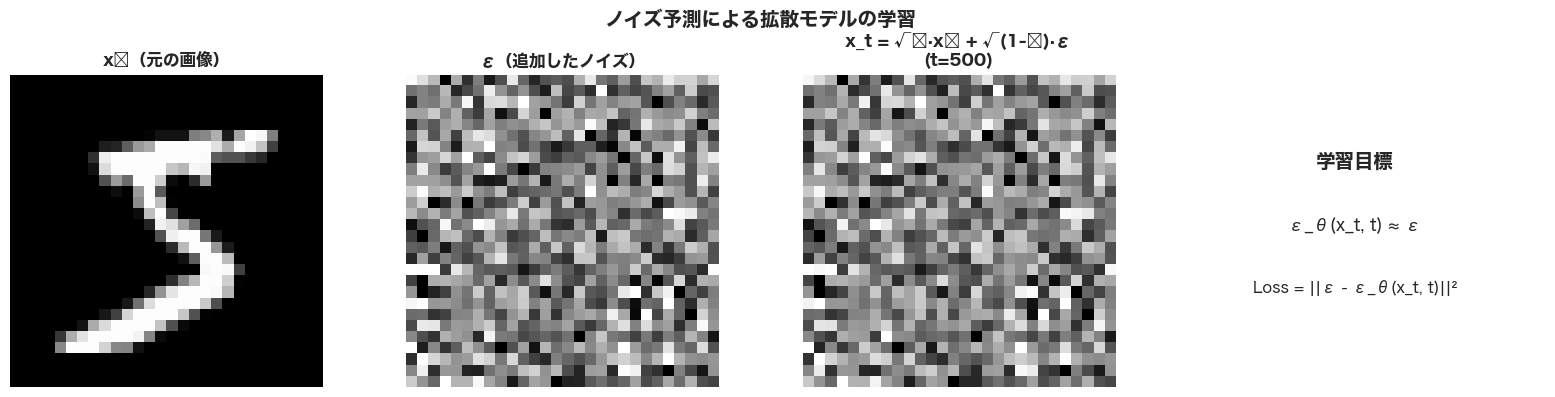

In [10]:
# ============================================================
# ノイズ予測の概念図
# ============================================================

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

torch.manual_seed(42)
t = 500

# 1. 元の画像 x_0
ax = axes[0]
ax.imshow(sample_image.squeeze().numpy(), cmap='gray')
ax.set_title('x₀（元の画像）', fontsize=12, fontweight='bold')
ax.axis('off')

# 2. ノイズ ε
noise = torch.randn_like(sample_image)
ax = axes[1]
ax.imshow(noise.squeeze().numpy(), cmap='gray', vmin=-2, vmax=2)
ax.set_title('ε（追加したノイズ）', fontsize=12, fontweight='bold')
ax.axis('off')

# 3. ノイズが追加された画像 x_t
alpha_bar_t = alpha_bars[t]
x_t = torch.sqrt(alpha_bar_t) * sample_image + torch.sqrt(1 - alpha_bar_t) * noise
ax = axes[2]
ax.imshow(x_t.squeeze().numpy(), cmap='gray', vmin=-2, vmax=2)
ax.set_title(f'x_t = √ᾱ·x₀ + √(1-ᾱ)·ε\n(t={t})', fontsize=12, fontweight='bold')
ax.axis('off')

# 4. 学習目標
ax = axes[3]
ax.text(0.5, 0.7, '学習目標', ha='center', fontsize=14, fontweight='bold')
ax.text(0.5, 0.5, 'ε_θ(x_t, t) ≈ ε', ha='center', fontsize=12)
ax.text(0.5, 0.3, 'Loss = ||ε - ε_θ(x_t, t)||²', ha='center', fontsize=11)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.suptitle('ノイズ予測による拡散モデルの学習', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 6. 訓練とサンプリングのアルゴリズム

### 📊 訓練アルゴリズム

```
repeat:
    1. データから x_0 をサンプル
    2. t を [1, T] から一様にサンプル
    3. ノイズ ε ~ N(0, I) をサンプル
    4. x_t = sqrt(α_bar_t) * x_0 + sqrt(1 - α_bar_t) * ε を計算
    5. 損失 L = ||ε - ε_θ(x_t, t)||² を計算
    6. 勾配降下でパラメータ θ を更新
until 収束
```

### 📊 サンプリングアルゴリズム（DDPM）

```
1. x_T ~ N(0, I) をサンプル
2. for t = T, T-1, ..., 1:
    a. z ~ N(0, I) if t > 1 else z = 0
    b. ε_θ = ε_θ(x_t, t) でノイズを予測
    c. x_{t-1} = (1/sqrt(α_t)) * (x_t - (β_t/sqrt(1-α_bar_t)) * ε_θ) + σ_t * z
3. return x_0
```

In [11]:
# ============================================================
# 訓練アルゴリズムの疑似コード実装
# ============================================================

def training_step(model, x_0, optimizer, betas, alpha_bars):
    """
    1ステップの訓練
    
    Parameters:
    -----------
    model : nn.Module
        ノイズ予測モデル ε_θ(x_t, t)
    x_0 : Tensor
        元のデータ (batch_size, C, H, W)
    """
    batch_size = x_0.shape[0]
    T = len(betas)
    
    # 1. ランダムなタイムステップを選択
    t = torch.randint(0, T, (batch_size,))
    
    # 2. ノイズをサンプル
    noise = torch.randn_like(x_0)
    
    # 3. x_t を計算
    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)  # ブロードキャスト用
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    
    # 4. ノイズを予測
    noise_pred = model(x_t, t)
    
    # 5. 損失を計算
    loss = F.mse_loss(noise_pred, noise)
    
    # 6. 勾配降下
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

print("✅ 訓練ステップの疑似コードを定義しました")
print("\n実際の訓練には、U-Netなどのモデルが必要です。")
print("次のノートブックで詳しく実装します。")

✅ 訓練ステップの疑似コードを定義しました

実際の訓練には、U-Netなどのモデルが必要です。
次のノートブックで詳しく実装します。


In [12]:
# ============================================================
# サンプリングアルゴリズムの疑似コード実装
# ============================================================

def ddpm_sampling(model, shape, betas, alpha_bars, device='cpu'):
    """
    DDPMサンプリング
    
    Parameters:
    -----------
    model : nn.Module
        学習済みのノイズ予測モデル
    shape : tuple
        生成する画像のサイズ (batch_size, C, H, W)
    """
    T = len(betas)
    alphas = 1 - betas
    
    # 1. x_T ~ N(0, I) からスタート
    x_t = torch.randn(shape).to(device)
    
    # 2. 逆方向にイテレート
    for t in reversed(range(T)):
        # ノイズ（t=0 では追加しない）
        z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)
        
        # ノイズを予測
        t_tensor = torch.full((shape[0],), t, dtype=torch.long).to(device)
        noise_pred = model(x_t, t_tensor)
        
        # x_{t-1} を計算
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        beta_t = betas[t]
        
        # 分散（簡略化版）
        sigma_t = torch.sqrt(beta_t)
        
        # 更新式
        x_t = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred
        ) + sigma_t * z
    
    return x_t

print("✅ DDPMサンプリングの疑似コードを定義しました")

✅ DDPMサンプリングの疑似コードを定義しました


---

## 7. ノイズスケジュールの比較

ノイズスケジュール $\beta_t$ の選び方は、拡散モデルの性能に大きく影響します。

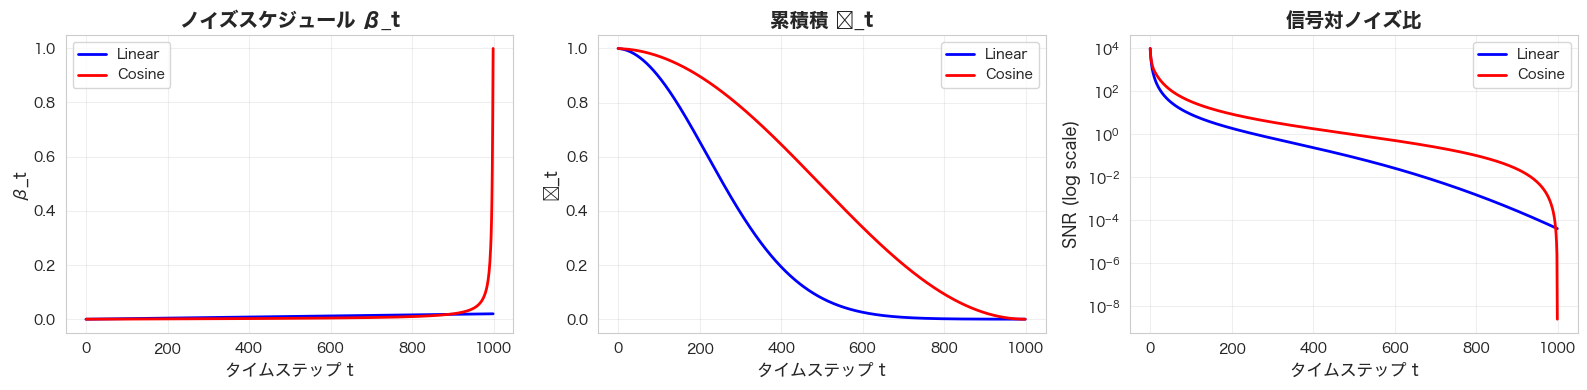

💡 Cosineスケジュールの利点:
  - 初期段階でのノイズ追加が緩やか
  - 終盤でのノイズ追加が速い
  - より滑らかな拡散過程


In [13]:
# ============================================================
# Linear vs Cosine スケジュールの比較
# ============================================================

T = 1000

# 各スケジュール
betas_linear = get_beta_schedule(T, 'linear')
betas_cosine = get_beta_schedule(T, 'cosine')

# α_bar を計算
alpha_bars_linear = torch.cumprod(1 - betas_linear, dim=0)
alpha_bars_cosine = torch.cumprod(1 - betas_cosine, dim=0)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# β_t
ax = axes[0]
ax.plot(betas_linear.numpy(), 'b-', linewidth=2, label='Linear')
ax.plot(betas_cosine.numpy(), 'r-', linewidth=2, label='Cosine')
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('β_t', fontsize=12)
ax.set_title('ノイズスケジュール β_t', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# α_bar_t
ax = axes[1]
ax.plot(alpha_bars_linear.numpy(), 'b-', linewidth=2, label='Linear')
ax.plot(alpha_bars_cosine.numpy(), 'r-', linewidth=2, label='Cosine')
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('ᾱ_t', fontsize=12)
ax.set_title('累積積 ᾱ_t', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 信号対ノイズ比 (SNR)
ax = axes[2]
snr_linear = alpha_bars_linear / (1 - alpha_bars_linear + 1e-8)
snr_cosine = alpha_bars_cosine / (1 - alpha_bars_cosine + 1e-8)
ax.semilogy(snr_linear.numpy(), 'b-', linewidth=2, label='Linear')
ax.semilogy(snr_cosine.numpy(), 'r-', linewidth=2, label='Cosine')
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('SNR (log scale)', fontsize=12)
ax.set_title('信号対ノイズ比', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Cosineスケジュールの利点:")
print("  - 初期段階でのノイズ追加が緩やか")
print("  - 終盤でのノイズ追加が速い")
print("  - より滑らかな拡散過程")

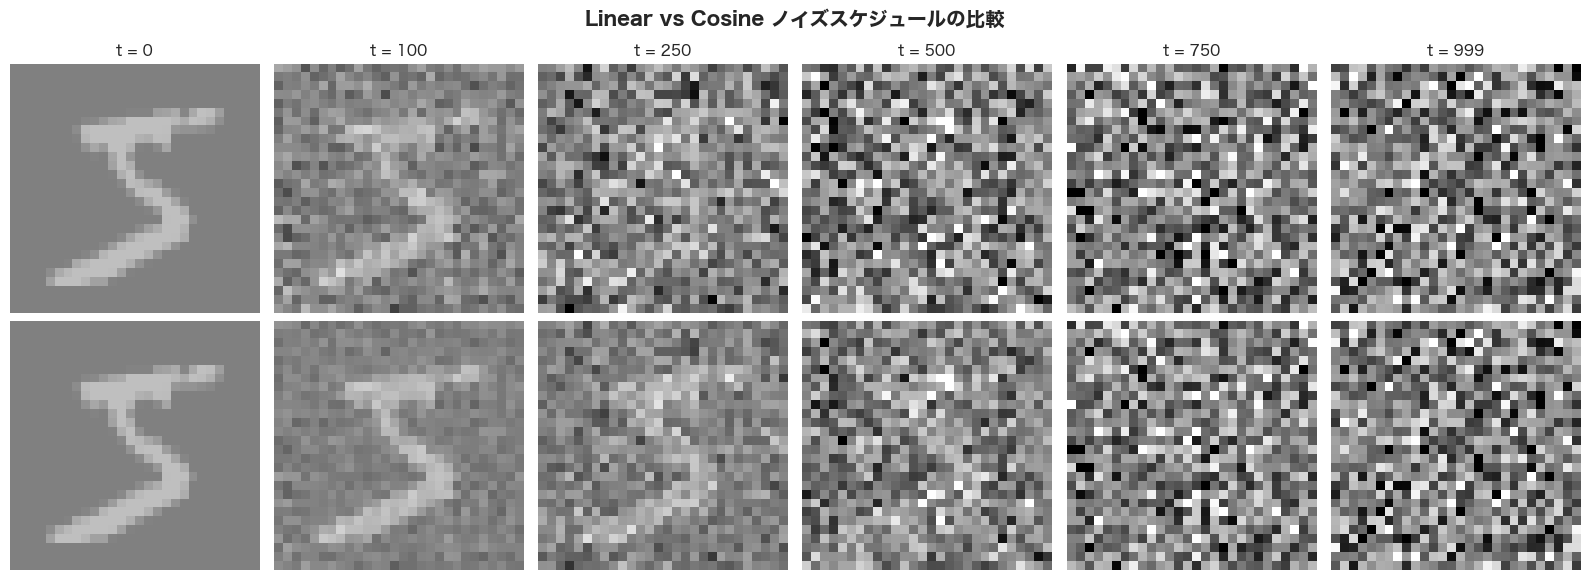

In [14]:
# ============================================================
# スケジュール別の拡散過程比較
# ============================================================

display_steps = [0, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(2, len(display_steps), figsize=(16, 6))

torch.manual_seed(42)

for idx, t in enumerate(display_steps):
    # Linear
    if t == 0:
        x_linear = sample_image
    else:
        noise = torch.randn_like(sample_image)
        x_linear = torch.sqrt(alpha_bars_linear[t-1]) * sample_image + \
                   torch.sqrt(1 - alpha_bars_linear[t-1]) * noise
    
    axes[0, idx].imshow(x_linear.squeeze().numpy(), cmap='gray', vmin=-2, vmax=2)
    axes[0, idx].set_title(f't = {t}', fontsize=11)
    axes[0, idx].axis('off')
    if idx == 0:
        axes[0, idx].set_ylabel('Linear', fontsize=12)

torch.manual_seed(42)

for idx, t in enumerate(display_steps):
    # Cosine
    if t == 0:
        x_cosine = sample_image
    else:
        noise = torch.randn_like(sample_image)
        x_cosine = torch.sqrt(alpha_bars_cosine[t-1]) * sample_image + \
                   torch.sqrt(1 - alpha_bars_cosine[t-1]) * noise
    
    axes[1, idx].imshow(x_cosine.squeeze().numpy(), cmap='gray', vmin=-2, vmax=2)
    axes[1, idx].axis('off')
    if idx == 0:
        axes[1, idx].set_ylabel('Cosine', fontsize=12)

plt.suptitle('Linear vs Cosine ノイズスケジュールの比較', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## まとめ

### 🎯 このノートブックで学んだこと

**VAEから拡散モデルへ**
- ✓ 拡散モデルは「多段階VAE」として理解できる
- ✓ 潜在変数はデータと同じ次元（ノイズを加えた画像）
- ✓ エンコーダは固定（ノイズ追加）、デコーダのみ学習

**拡散過程（Forward Process）**
- ✓ $q(x_t | x_{t-1}) = \mathcal{N}(\sqrt{1-\beta_t} x_{t-1}, \beta_t I)$
- ✓ 直接ノイズ追加: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
- ✓ $\bar{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_s)$

**逆拡散過程（Reverse Process）**
- ✓ $p_\theta(x_{t-1} | x_t)$ をニューラルネットワークで学習
- ✓ ノイズ $\epsilon$ を予測する定式化が一般的
- ✓ 損失関数: $L = ||\epsilon - \epsilon_\theta(x_t, t)||^2$

**ノイズスケジュール**
- ✓ Linear: シンプルだが効果的
- ✓ Cosine: より滑らかな拡散過程

### 📊 拡散モデルチートシート

| 項目 | 式 |
|------|----|
| Forward | $q(x_t \| x_{t-1}) = \mathcal{N}(\sqrt{1-\beta_t} x_{t-1}, \beta_t I)$ |
| 直接ノイズ追加 | $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$ |
| $\bar{\alpha}_t$ | $\prod_{s=1}^{t} (1 - \beta_s)$ |
| 損失関数 | $L = \|\epsilon - \epsilon_\theta(x_t, t)\|^2$ |
| サンプリング | $x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta) + \sigma_t z$ |

---

## 🎓 自己評価クイズ

### Q1: VAEと拡散モデルの主な違いは何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:

| 項目 | VAE | 拡散モデル |
|------|-----|------------|
| 潜在変数 | 1つ（低次元） | T個（データと同次元） |
| エンコーダ | 学習（NN） | 固定（ノイズ追加） |
| デコーダ | 学習（NN） | 学習（ノイズ予測NN） |
| 生成過程 | 1ステップ | Tステップ |

</details>

---

### Q2: $q(x_t | x_0)$ を直接計算できることの利点は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:

- 訓練時に任意のタイムステップ $t$ の $x_t$ を1回の計算で得られる
- 逐次的に計算する必要がない（計算効率が良い）
- ランダムな $t$ をサンプルして効率的に訓練できる

</details>

---

### Q3: なぜノイズ $\epsilon$ を予測するのが一般的ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:

- $\epsilon$ が分かれば $x_0$ を逆算できる: $x_0 = (x_t - \sqrt{1-\bar{\alpha}_t} \epsilon) / \sqrt{\bar{\alpha}_t}$
- $\epsilon \sim \mathcal{N}(0, I)$ は標準正規分布なので、予測対象が安定
- すべてのタイムステップで同じスケールのターゲット
- 実験的に良い結果が得られている

</details>

---

### Q4: Cosineスケジュールの利点は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:

- 初期段階でのノイズ追加が緩やか（画像の構造が長く保持される）
- 終盤でのノイズ追加が速い
- SNRがより滑らかに減少する
- 特に高解像度画像で効果的

</details>

---

### ✅ 学習チェックリスト

- [ ] VAEと拡散モデルの関係を説明できる
- [ ] 拡散過程の数式を書ける
- [ ] $q(x_t | x_0)$ の閉形式を導出できる
- [ ] 逆拡散過程の概念を説明できる
- [ ] ノイズスケジュールの違いを説明できる

---

**次のステップ**: Notebook 38で、**拡散モデルの理論（ELBO導出編）**を学びます！

ELBOの詳細な導出と、なぜノイズ予測が最適化の観点から正当化されるかを理解します。